In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict
from helpers.preprocessing import expand_ann, nearest_neighbors_ann, normalize_data
import os

In [ ]:
NORMALIZE = True

In [7]:
all_train_files = os.listdir('training_data')
num_subjects = 8
out_dir = 'processed_training_data'

In [12]:
all_train_files = os.listdir('training_data')
num_subjects = 8

for subject_num in range(1, num_subjects + 1):
    query_str = f'subject_00{subject_num}'
    subject_files = [x for x in all_train_files if query_str == x[:len(query_str)]]
    
    num_trials = len(subject_files) / 4
    assert num_trials.is_integer()
    num_trials = int(num_trials)
    
    for trial_num in range(1, num_trials + 1):
        imu = pd.read_csv(f'training_data/subject_00{subject_num}_0{trial_num}__x.csv',
                          names=['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z'])
        imu_t = pd.read_csv(f'training_data/subject_00{subject_num}_0{trial_num}__x_time.csv', names=['time'])
        ann = pd.read_csv(f'training_data/subject_00{subject_num}_0{trial_num}__y.csv', names=['labels'])
        ann_t = pd.read_csv(f'training_data/subject_00{subject_num}_0{trial_num}__y_time.csv', names=['time'])
        
        expanded_ann = nearest_neighbors_ann(
            imu_t['time'].tolist(),
            ann['labels'].tolist(),
            ann_t['time'].tolist()
        )
        
        # expanded_ann = expand_ann(
        #     imu_t['time'].tolist(),
        #     ann['labels'].tolist(),
        #     ann_t['time'].tolist()
        # )
        
        if NORMALIZE:
            cols = imu.columns
            norm_imu = normalize_data(imu.to_numpy(), method='standard')[0]
            df_norm_imu = pd.DataFrame(norm_imu, columns=cols)
        else:
            df_norm_imu = imu
        
        # Verify lengths are the same
        assert len(expanded_ann['ann']) == len(imu)
        
        df_norm_imu.to_csv(f'{out_dir}/subject_00{subject_num}_0{trial_num}__x.csv', index=False)
        imu_t.to_csv(f'{out_dir}/subject_00{subject_num}_0{trial_num}__x_time.csv', index=False)
        pd.DataFrame(expanded_ann['ann'], columns=['labels']).to_csv(
            f'{out_dir}/subject_00{subject_num}_0{trial_num}__y.csv', index=False)
        pd.DataFrame(expanded_ann['ann_time'], columns=['time']).to_csv(
            f'{out_dir}/subject_00{subject_num}_0{trial_num}__y_time.csv', index=False)
        

In [13]:
# Verify lengths are the same
assert len(expanded_ann['ann']) == len(imu)

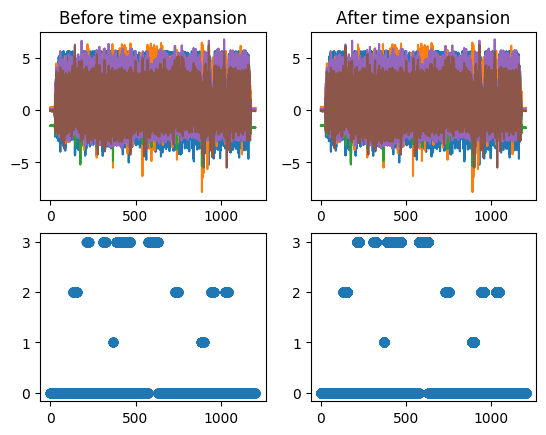

In [14]:
fig, axs = plt.subplots(2,2)
axs[0][0].plot(imu_t.to_numpy(), df_norm_imu.to_numpy())
axs[0][0].set_title('Before time expansion')
axs[1][0].scatter(ann_t.to_numpy(), ann.to_numpy())
axs[0][1].set_title('After time expansion')
axs[0][1].plot(imu_t.to_numpy(), df_norm_imu.to_numpy())
axs[1][1].scatter(expanded_ann['ann_time'], expanded_ann['ann'])